In [14]:
import anuga
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

lat_ll, lon_ll = -34.2, 150.5
lat_ur, lon_ur = -33.2, 151.5

crop = 0.05

In [38]:
# Download elevation data for Sydney area
import elevation
import os
cwd = os.getcwd()

tif_filename = anuga.join(cwd,r'Sydney-DEM.tif')


elevation.clip(bounds=(lon_ll-crop, lat_ll-crop, lon_ur+crop, lat_ur+crop), 
               output=tif_filename)

elevation.clean()

make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.f39caf0f06344e3db6d0c7251b1f395c.vrt
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 150.45 -33.150000000000006 151.55 -34.25 SRTM1.f39caf0f06344e3db6d0c7251b1f395c.vrt /home/anuga/anuga_core/Sydney-DEM.tif
rm -f SRTM1.f39caf0f06344e3db6d0c7251b1f395c.vrt
make: Leaving directory '/home/anuga/.cache/elevation/SRTM1'
make: Entering directory '/home/anuga/.cache/elevation/SRTM1'
find cache -size 0 -name "*.tif" -delete
rm -f SRTM

3960 3960
-32768.0


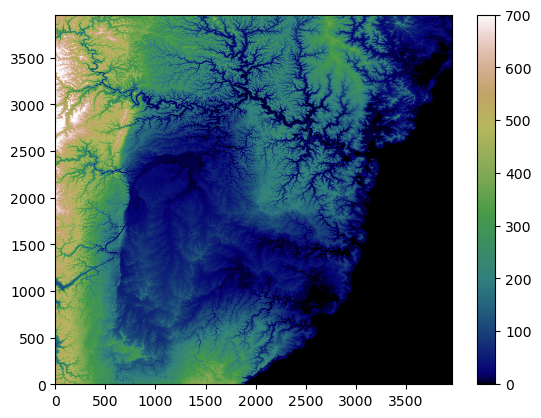

In [15]:
from osgeo import gdal

dataset = gdal.Open(r'Sydney-DEM.tif')
#print(dataset.RasterCount)
print(dataset.RasterXSize, dataset.RasterYSize)

band1 = dataset.GetRasterBand(1)
novalue = band1.GetNoDataValue()

print(novalue)

b1 = band1.ReadAsArray()

b1 = np.flipud(b1)

#plt.figure(figsize=(10,10))
ax = plt.axes()
plt.pcolormesh(b1, cmap='gist_earth', vmin=-1.0, vmax=700)
plt.colorbar()
plt.show()

In [16]:
def zone_letter_to_hemisphere(zone_letter):
    hemisphere = 'undefined'
    if zone_letter.lower() in 'cdefghjklm':
        hemisphere = 'southern'
    if zone_letter.lower() in 'npqrstuvwx':
        hemisphere = 'northern'
        
    return hemisphere

import utm

utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll = utm.from_latlon(lat_ll, lon_ll)
utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur = utm.from_latlon(lat_ur, lon_ur)

hemi_ll = zone_letter_to_hemisphere(zone_dd_ll)
hemi_ur = zone_letter_to_hemisphere(zone_dd_ll)


print(utm_east_ll, utm_north_ll, zone_ll, zone_dd_ll, hemi_ll)
print(utm_east_ur, utm_north_ur, zone_ur, zone_dd_ur, hemi_ur)

utm_east_len = utm_east_ur - utm_east_ll
utm_north_len = utm_north_ur - utm_north_ll

utm_origin = (utm_east_ll, utm_north_ll)

print(utm_east_len, utm_north_len)

269645.77398930304 6212842.207926389 56 H southern
360186.80045065586 6325538.419045925 56 H southern
90541.02646135283 112696.21111953631


In [17]:
domain = anuga.rectangular_cross_domain(200,200,
                               len1=utm_east_len,
                               len2=utm_north_len,
                               origin=utm_origin)
domain.set_zone(zone_ll)
domain.set_hemisphere(hemi_ll)

dplotter = anuga.Domain_plotter(domain) # should set this up via a set_plotter command

Br = anuga.Reflective_boundary(domain)
domain.set_boundary({'left': Br, 'right': Br, 'top': Br, 'bottom': Br})

# Put some rain on the domain
anuga.Rate_operator(domain, rate=0.001);


# Use tif file to set elevation
domain.set_quantity('elevation', 
                    filename = r'Sydney-DEM.tif', 
                    location='centroids')

domain.set_quantity('friction', 0.01)

# Note that quantities (in particular stage) have a default value of zero

Figure files for each frame will be stored in _plot


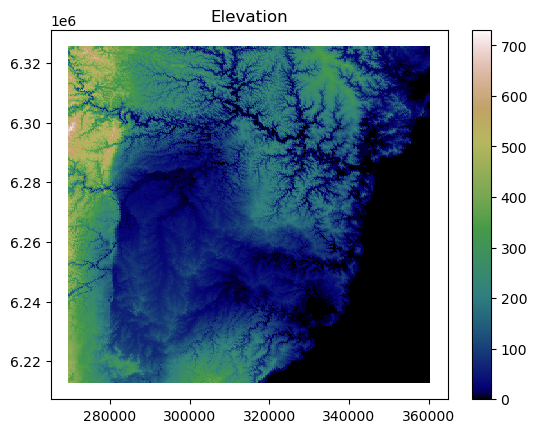

In [18]:
#plt.figure(figsize=(10,16))
plt.tripcolor(dplotter.triang,
              facecolors = dplotter.elev,
              cmap='gist_earth',
              vmin = 0.0)
plt.colorbar();
plt.title("Elevation");

In [19]:
for t in domain.evolve(yieldstep=300, finaltime=1200):
    domain.print_timestepping_statistics()

Time = 0.0000 (sec), steps=0 (20s)
Time = 300.0000 (sec), delta t in [1.17244047, 1.17295293] (s), steps=256 (15s)
Time = 600.0000 (sec), delta t in [1.17192725, 1.17243882] (s), steps=256 (14s)
Time = 900.0000 (sec), delta t in [1.17141045, 1.17192538] (s), steps=257 (14s)
Time = 1200.0000 (sec), delta t in [1.17083041, 1.17141036] (s), steps=257 (14s)


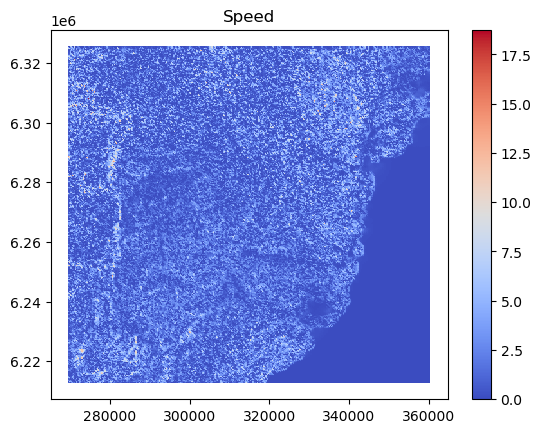

In [56]:
depth = dplotter.stage - dplotter.elev 
speed = np.sqrt(dplotter.xmom**2 + dplotter.ymom**2 ) / depth

#plt.figure(figsize=(10,16))
plt.tripcolor(dplotter.triang,
              facecolors = speed,
              cmap='coolwarm')
plt.colorbar();
plt.title("Speed");